In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import PIL
import json
import logging
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
configuration = Config()
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

In [4]:
from dataset import overall_joints_dataset
from prediction import joint_damage
from dataset.joints.joint_extractor_factory import get_joint_extractor

In [5]:
def robust_mean(scores):
    scores = np.sort(scores)
    size_p = len(scores)//10
    mean_score = np.mean(scores[size_p:len(scores)-size_p])
    return mean_score
    
def _prepare_image(img_arr):
    imgs = [np.expand_dims(x.numpy(),0) for x in img_arr]
    return imgs

In [6]:
hands_model = keras.models.load_model("weights/SC1_v3A_hand_narrowing_maeafter_model_40.h5")

In [7]:
hand_extractor = get_joint_extractor("H", False) 
ds = overall_joints_dataset.hands_overall_joints_dataset(configuration, 'test', joint_extractor = hand_extractor, force_augment = True).create_hands_overall_joints_dataset("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv",joints_source = './data/predictions/hand_joint_data_test_v2.csv')


In [8]:
results = {}

In [12]:

for x in ds:
    imgs, img_id = _prepare_image(x[1]), x[0].numpy()[0].decode("utf-8")
    res = hands_model.predict(imgs)
    try:
        results[img_id].append(res[0][0])
    except:
        results[img_id] = [res[0][0]]

In [24]:
a = result.sum(axis=1)

In [29]:
ground_truth_df["lol"] = a

In [30]:
ground_truth_df

,Overall_Tol,Overall_erosion,Overall_narrowing,LH_mcp_E__ip,LH_pip_E__2,LH_pip_E__3,LH_pip_E__4,LH_pip_E__5,LH_mcp_E__1,LH_mcp_E__2,...,LF_mtp_J__3,LF_mtp_J__4,LF_mtp_J__5,RF_mtp_J__ip,RF_mtp_J__1,RF_mtp_J__2,RF_mtp_J__3,RF_mtp_J__4,RF_mtp_J__5,lol
Patient_ID,,,,,,,,,,,,,,,,,,,,,
UAB001,45,2,43,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,2,NaN
UAB002,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.566461
UAB003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
UAB005,6,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
UAB006,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAB716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.019342
UAB717,20,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
UAB719,25,1,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [14]:
for item in results:
    results[item] = robust_mean(results[item])

In [15]:
result = pd.DataFrame.from_dict(results,orient='index')
result.columns = ["Prediction"]
result["patient"] = result.index.str.split("-").str[0]
result["side"] = result.index.str.split("-").str[1]
result = result.pivot(index = "patient", values="Prediction", columns="side")

In [27]:
ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
ground_truth_df = ground_truth_df.set_index("Patient_ID")
what = ".*H.*J.*"
what = re.compile(what)
wanted_cols = list(filter(what.match, ground_truth_df.columns))
merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
truth_idx = ["LH_" in x for x in merged_df.columns]
merged_df["Overall_truth LH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
truth_idx = ["RH_" in x for x in merged_df.columns]
merged_df["Overall_truth RH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)


In [21]:
merged_df[["LH","RH","Overall_truth LH","Overall_truth RH"]]

,LH,RH,Overall_truth LH,Overall_truth RH
patient,,,,
UAB002,0.280556,0.228263,2,0
UAB018,0.003399,0.367139,0,0
UAB030,0.490818,1.063584,0,0
UAB032,8.078384,16.274839,6,14
UAB036,1.328471,1.016839,2,4
...,...,...,...,...
UAB700,0.801712,0.663400,0,0
UAB701,4.854816,7.669703,22,18
UAB706,38.978977,42.757824,60,60


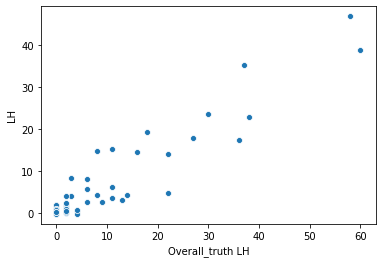

In [22]:
sns.scatterplot(data = merged_df, x="Overall_truth LH",y="LH")

In [23]:
mean_absolute_error(merged_df["Overall_truth LH"],merged_df["LH"])

2.4822833907345068

# feet

In [6]:
feet_model = keras.models.load_model("weights/SC1_v3A_feet_erosion_mae_adamafter_model_100.h5")

In [7]:
foot_extractor = get_joint_extractor("F", False)
ds = overall_joints_dataset.feet_overall_joints_dataset(configuration, 'test', joint_extractor = foot_extractor).create_feet_overall_joints_dataset("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv",joints_source = './data/predictions/feet_joint_data_test_v2.csv')


In [8]:
results = {}
for x in ds:
    imgs, img_id = _prepare_image(x[1]), x[0].numpy()[0].decode("utf-8")
    res = feet_model.predict(imgs)
    try:
        results[img_id].append(res[0][0])
    except:
        results[img_id] = [res[0][0]]

In [9]:
for item in results:
    results[item] = sum(results[item])/len(results[item])

In [10]:
result = pd.DataFrame.from_dict(results,orient='index')
result.columns = ["Prediction"]
result["patient"] = result.index.str.split("-").str[0]
result["side"] = result.index.str.split("-").str[1]
result = result.pivot(index = "patient", values="Prediction", columns="side")

In [11]:
ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
ground_truth_df = ground_truth_df.set_index("Patient_ID")
what = ".*F.*E.*"
what = re.compile(what)
wanted_cols = list(filter(what.match, ground_truth_df.columns))
merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
truth_idx = ["LF_" in x for x in merged_df.columns]
merged_df["Overall_truth LF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
truth_idx = ["RF_" in x for x in merged_df.columns]
merged_df["Overall_truth RF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)


In [12]:
merged_df[["LF","RF","Overall_truth LF","Overall_truth RF"]]

,LF,RF,Overall_truth LF,Overall_truth RF
patient,,,,
UAB002,0.449816,0.726297,0,0
UAB018,0.139782,0.234480,0,0
UAB030,0.092403,0.648506,0,0
UAB032,2.785679,5.465184,6,5
UAB036,2.723035,-0.081357,2,2
...,...,...,...,...
UAB700,-0.102584,2.466112,0,4
UAB701,1.382967,3.080368,5,6
UAB706,6.627244,5.019684,15,17


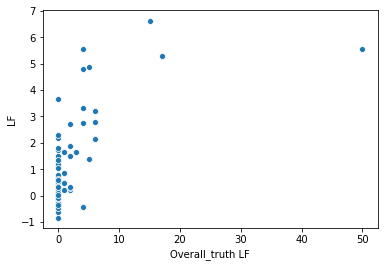

In [13]:
sns.scatterplot(data = merged_df, x="Overall_truth LF",y="LF")

In [14]:
mean_absolute_error(merged_df["Overall_truth LF"],merged_df["LF"])

1.4442365075583043

In [15]:
mean_absolute_error(merged_df["Overall_truth RF"],merged_df["RF"])

1.352673969676961